# Thomas-Fermi-Debye model for bremsstrahlung cross sections

Written by Michael Lavell. April 22, 2024

Based on B. Martinez et al, Phys. Plasmas 26, 103109 (2019) and notes provided by B. Martinez

In [1]:
import numpy as np
from scipy import constants
import matplotlib.pyplot as plt
import math as m

plt.style.use('../utils/minimal.style')

# electron rest mass
me_c2 = constants.electron_mass * constants.c**2
# Compton radius
r_c = constants.hbar / (constants.electron_mass * constants.c)
# normalized fine structure constant
alpha_f = constants.e**2 / (4.0 * constants.pi * constants.epsilon_0 * constants.hbar * constants.c)
# normalized electron radius
r_e = constants.e**2 / (4.0 * constants.pi * constants.epsilon_0 * constants.electron_mass * constants.c**2)

# (gamma - 1)mc^2 = E
# (1 - (v/c)^2)^-1/2 = 1 + E/(mc^2)
def calc_beam_velocity_EeV(EeV, m):
    return constants.c * (1.0 - (1.0 + constants.eV * EeV / (m * constants.c**2))**-2)**0.5

In [2]:
# Thomas-Fermi ionization state Z_eff for any temperature, density, atomic number, atomic weight
# It comes from Table IV of the paper cited by B Martinez.

def ThomasFermi_Zeff(T, density, atn, atw):
    a1 = 0.003323
    a2 = 0.9718
    a3 = 9.26148e-5
    a4 = 3.10165
    b0 = -1.7630
    b1 = 1.43175
    b2 = 0.31546
    c1 = -0.366667
    c2 = 0.983333

    Temp = T # temperature in eV
    rho = density # density in g/cc
    Z = atn # atomic number
    A = atw # atomic weight, total nucleons
    alpha = 14.3139
    beta = 0.6624

    T0 = Temp / Z**(4.0/3.0)
    R = rho / (Z * A)
    Tf = T0 / (1.0 + T0)
    A = (a1 * T0**a2) + (a3 * T0**a4);
    B = -1.0*np.exp(b0 + b1*Tf + b2*Tf**7.0);
    C = c1*Tf + c2;
    Q1 = A * R**B;
    Q  = ( R**C + Q1**C )**(1.0 / C);
    x = alpha * (Q**beta);
    Zeff = Z * x / (1.0 + x + np.sqrt(1.0 + 2.0*x));
    return Zeff


def ThomasFermi_T0(rho, Z, A):
    # Calculation for T = 0
    alpha = 14.3139
    beta = 0.6624
    x = alpha*(rho/(Z*A))**beta
    f = x/(1. + x + np.sqrt(1.0+2*x))
    Zeff = f*Z
    # dZeffdrho = (Zeff/rho)*(beta/sqrt(1.+2.*x));
    
    return Zeff

# # Solid copper is density=8.9, atn=29, atw=63.546
# cu_rho = 8.9 # density in g/cc
# cu_Z = 29 # atomic number
# cu_A = 63.546 # atomic weight, total nucleons

# Temps = [0, 1, 100, 10e3]

# myTs = np.logspace(-5, 5, 100) #10^span(-5.,5.,601);
# myZs = ThomasFermi_Zeff(myTs, cu_rho, cu_Z, cu_A);

# fig,ax = plt.subplots(1,1,figsize=(5,4))
# ax.plot(myTs, myZs)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlabel("T (eV)")
# ax.set_ylabel(r"$Z_{\mathrm{eff}}$")
# ax.grid()

In [3]:
# Functions for characteristic path lengths

def lThomasFermi(Z):
    ltf = 4.0 * constants.pi * constants.epsilon_0 * constants.hbar**2 \
          / (constants.m_e * constants.e**2) * Z**(-1.0/3.0)
    # BM code has extra factor of 0.885
    return ltf / r_c * 0.885

def lDebye(TeV, ni, Zstar):
    ld = (constants.epsilon_0 * constants.e * TeV \
         / (constants.e**2 * ni * Zstar 
            * (Zstar + 1.0)))**0.5
    return ld / r_c

def lInteratomic(ni):
    lia = (4.0 * np.pi * ni / 3.0)**(-1.0/3.0)
    return lia / r_c

In [4]:
# Elwert factor

def Elwert_factor(Z, k, g1):
    ec = 1.0
    
    if ((k > 0.0) and (k < g1 - 1.0)):
        g2 = g1 - k
        b1 = np.sqrt(1.0 - 1.0 / g1**2)
        b2 = np.sqrt(1.0 - 1.0 / g2**2)
        
        if (Z * alpha_f * (1.0 / b2 - 1.0 / b1)) < 100.0:
            ec = b1/b2 * (1.0 - np.exp(-2.0 * np.pi * Z * alpha_f / b1)) / \
                         (1.0 - np.exp(-2.0 * np.pi * Z * alpha_f / b2))
    return ec

In [5]:
# Thomas-Fermi-Debye (screened) differential cross section
# Non-relativistic case

def dif_cs_tfd_nr(k, Z, g1, enable_ec=True):
    cs = 0.0
    
    if ((k > 0.0) and (k < g1-1.0)):
        
        g2 = g1 - k
        p1 = np.sqrt(g1**2 - 1.0)
        p2 = np.sqrt(g2**2 - 1.0)
        b1 = np.sqrt(1.0 - 1.0 / g1**2)
        b2 = np.sqrt(1.0 - 1.0 / g2**2)
        
        dp = p1 + p2 # maximum momentum (defined differently in paper..)
        dm = p1 - p2 # minimum momentum
    
        ##### ASSUMING ETA=1
        
        ltf = lThomasFermi(Z)
        
        # result shown in paper has 1/b1**2 instead of 1/p1**2 in eq.8
        T1 = 16.0 * (Z * r_e)**2 * alpha_f / (3.0 * k * p1**2)
        
        T2 = 0.5 * (np.log(((dp * ltf)**2 + 1.0) / ((dm * ltf)**2 + 1.0)) +
                    1.0 / ((dp * ltf)**2 + 1.0) - 1.0 / ((dm * ltf)**2 + 1.0))
        
        T3 = 1.0
        if enable_ec:
            T3 = Elwert_factor(Z, k, g1)
        
        cs = T1 * T2 * T3
        
    return cs

def g_func(eta, dp, dm, l):
    dpl_p1 = (dp * l)**2 + 1
    dml_p1 = (dm * l)**2 + 1
    val = 0.5 * eta**2 * (np.log(dpl_p1 / dml_p1) + 
                          1.0 / dpl_p1 - 1.0 / dml_p1)
    return val

def dif_cs_tfd_nr2(k, Z, Zstar, T, ni, g1, enable_ec=True):
    cs = 0.0

    if ((k > 0.0) and (k < g1-1.0)):

        g2 = g1 - k
        p1 = np.sqrt(g1**2 - 1.0)
        p2 = np.sqrt(g2**2 - 1.0)
        b1 = np.sqrt(1.0 - 1.0 / g1**2)
        b2 = np.sqrt(1.0 - 1.0 / g2**2)

        dp = p1 + p2 # maximum momentum (defined differently in paper..)
        dm = p1 - p2 # minimum momentum

        eta_tf = 1.0 - Zstar / Z
        eta_d = Zstar / Z

        ltf = lThomasFermi(Z)

        # result shown in paper has 1/b1**2 instead of 1/p1**2 in eq.8
        T_coef = 16.0 * (Z * r_e)**2 * alpha_f / (3.0 * k * p1**2)

        T_tf = g_func(eta_tf, dp, dm, ltf)

        T_d = 0.0
        T_coupling = 0.0

        if (Zstar > 0 and T > 0.0):
            ld = max(lDebye(T, ni, Zstar), lInteratomic(ni))
            T_d = g_func(eta_d, dp, dm, ld)

            T_coupling = eta_tf * eta_d / (ld**2 - ltf**2) * \
                         (ltf**2 * np.log(((dm * ld)**2 + 1.0) / ((dp * ld)**2 + 1.0)) +\
                          ld**2 * np.log(((dp * ltf)**2 + 1.0) / ((dm * ltf)**2 + 1.0)))

        T_ec = 1.0
        if enable_ec:
            T_ec = Elwert_factor(Z, k, g1)

        cs = T_coef * (T_tf + T_d + T_coupling) * T_ec

    return cs

In [6]:
# Compute differential cross section for 100 keV electrons incident on copper
E = 100.0e3 # eV
gamma = 1.0 + (E * constants.e) / me_c2
gm1 = gamma - 1.0

Z = 29
A = 63.546 # atomic weight, total nucleons
rho = 8.9 # density in g/cc
ni_cc = rho * constants.Avogadro / A
ni = ni_cc * 1e6 # m^-3

T = 0
Zstar = 0

nk = 100
ks = np.linspace(0.0, gm1, nk)
ks_over_gm1 = ks / gm1

dsdk_tfd = np.array([ dif_cs_tfd_nr(k, Z, gamma) for k in ks ])
kdsdk_tfd = ks * dsdk_tfd

dsdk_tfd2 = np.array([ dif_cs_tfd_nr2(k, Z, Zstar, T, ni, gamma) for k in ks ])
kdsdk_tfd2 = ks * dsdk_tfd2

# Include factor to get what is shown in paper
p_e = np.sqrt(gamma**2 - 1.0)
b_e = np.sqrt(1.0 - (1.0 / gamma**2))
kdsdk_tfd_err = ks * dsdk_tfd * (p_e / b_e)**2


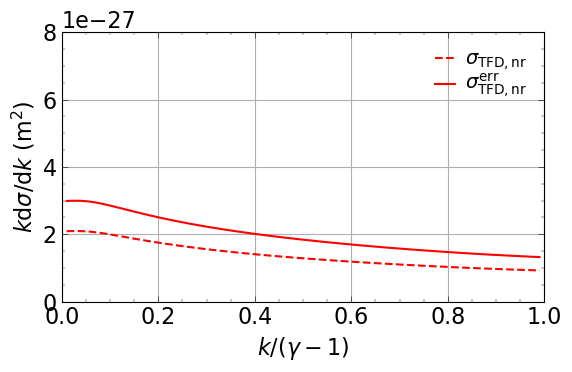

In [7]:
# Reproduce Figure 2

fig,ax = plt.subplots(1, 1, figsize=(6,4))
ax.set_xlabel(r'$k/(\gamma-1)$')
ax.set_ylabel(r'$k\mathrm{d}\sigma/\mathrm{d}k$ (m$^2$)')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 8.0e-27])
ax.grid()

ax.plot(ks_over_gm1[1:-1], kdsdk_tfd[1:-1], '--r', label=r'$\sigma_{\rm TFD,nr}$')
ax.plot(ks_over_gm1[1:-1], kdsdk_tfd_err[1:-1], '-r', label=r'$\sigma_{\rm TFD,nr}^{\rm err}$')

ax.legend()
plt.tight_layout()
plt.show()

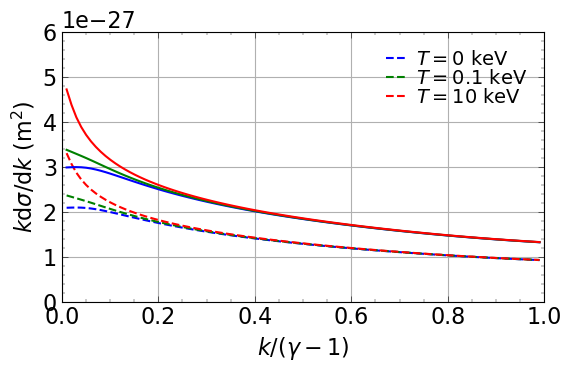

In [8]:
# Reproduce Figure 3

T = [0.0, 100.0, 10.0e3] #eV

kdsdk = np.zeros([nk,len(T)])

for i in range(len(T)):
    
    # For T = 0, set Zstar = 0 instead of getting it from TF model in order to match paper
    if i==0: Zstar = 0
    else:    Zstar = ThomasFermi_Zeff(T[i], rho, Z, A)
    
    dsdk_tfd = np.array([ dif_cs_tfd_nr2(k, Z, Zstar, T[i], ni, gamma) for k in ks ])
    kdsdk[:,i] = ks * dsdk_tfd

fig,ax = plt.subplots(1, 1, figsize=(6,4))
ax.set_xlabel(r'$k/(\gamma-1)$')
ax.set_ylabel(r'$k\mathrm{d}\sigma/\mathrm{d}k$ (m$^2$)')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 6.0e-27])
ax.grid()

ax.plot(ks_over_gm1[1:-1], kdsdk[1:-1,0], '--b', label=r'$T=0$ keV')
ax.plot(ks_over_gm1[1:-1], kdsdk[1:-1,1], '--g', label=r'$T=0.1$ keV')
ax.plot(ks_over_gm1[1:-1], kdsdk[1:-1,2], '--r', label=r'$T=10$ keV')

err_term = (p_e / b_e)**2
ax.plot(ks_over_gm1[1:-1], kdsdk[1:-1,0] * err_term, '-b')
ax.plot(ks_over_gm1[1:-1], kdsdk[1:-1,1] * err_term, '-g')
ax.plot(ks_over_gm1[1:-1], kdsdk[1:-1,2] * err_term, '-r')

ax.legend()
plt.tight_layout()
plt.show()

## Differential cross sections for moderately relativistic electrons

In [9]:
# equation 16
def I1_screening(d, l, eta):
    T1 = l * d * (np.arctan(l * d) - np.arctan(l))
    T2 = - 0.5 * l**2 * (1.0 - d)**2 / (1.0 + l**2)
    T3 = 0.5 * np.log((1.0 + l**2) / (1.0 + (l * d)**2))
    return eta * (T1 + T2 + T3) # notes from Martinez had eta^2 here

# equation 17
def I2_screening(d, l, eta):
    T1 = 4.0 * (l * d)**3 * (np.arctan(d * l) - np.arctan(l))
    T2 = (1.0 + 3.0 * (l * d)**2) * np.log((1.0 + l**2) / (1.0 + (l * d)**2))
    T3 = (6.0 * l**4 * d**2) * np.log(d) / (1.0 + l**2)
    T4 = l**2 * (d - 1.0) * (d + 1.0 - 4.0 * (l * d)**2) / (1.0 + l**2)
    return 0.5 * eta * (T1 + T2 + T3 + T4)

# equation 19
def I_screening(ltf, ld, eta_tf, eta_d):
    ltf2_p1 = ltf**2 + 1.0
    ld2_p1 = ld**2 + 1.0
    
    Ttf = 0.5 * eta_tf**2 * (ltf2_p1 * np.log(ltf2_p1) - ltf**2) / ltf2_p1
    Td = 0.0
    Tc = 0.0
    if eta_d > 0.0:
        Td = 0.5 * eta_d**2 * (ld2_p1 * np.log(ld2_p1) - ld**2) / ld2_p1
        Tc = eta_tf * eta_d * (ld**2 * np.log(ltf2_p1) - ltf**2 * np.log(ld2_p1)) \
             / (ld**2 - ltf**2)
        
    return Ttf + Td + Tc

# equation 12
def dif_cs_tfd_mr(k, Z, Zstar, T, ni, g1):
    cs = 0.0

    if ((k > 0.0) and (k < g1-1.0)):

        eta_tf = 1.0 - Zstar / Z
        eta_d = Zstar / Z
        
        d = k / (2.0 * g1 * (g1 - k)) # momentum transfer
        ltf = lThomasFermi(Z)

        I1_tf = I1_screening(d, ltf, eta_tf)
        I2_tf = I2_screening(d, ltf, eta_tf)
        I1_d = 0.0
        I2_d = 0.0
        
        if (Zstar > 0.0 and T > 0.0):
            ld = max(lDebye(T, ni, Zstar), lInteratomic(ni))
            I1_d = I1_screening(d, ld, eta_d)
            I2_d = I2_screening(d, ld, eta_d)
        
        I1 = I1_tf + I1_d
        I2 = I2_tf + I2_d
        
        T_coef = 4.0 * (Z * r_e)**2 * alpha_f / k
        T1 = (1.0 + ((g1 - k) / g1)**2) * (I1 + 1.0)
        T2 = 2.0 / 3.0 * ((g1 - k)/ g1) * (I2 + 5.0 / 6.0)
        cs = T_coef * (T1 - T2)

    return cs

In [10]:
# Compute differential cross section for 100 keV electrons incident on copper
E = 5.0e6 # eV
gamma = 1.0 + (E * constants.e) / me_c2
gm1 = gamma - 1.0

T = 0.0
Zstar = 0

nk = 100
ks = np.linspace(0.0, gm1, nk)
ks_over_gm1 = ks / gm1

dsdk_tfd = np.array([ dif_cs_tfd_mr(k, Z, Zstar, T, ni, gamma) for k in ks ])
kdsdk_tfd = ks * dsdk_tfd

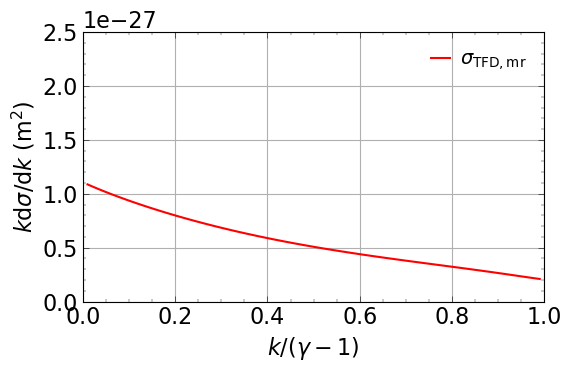

In [11]:
# Reproduce Figure 4

fig,ax = plt.subplots(1, 1, figsize=(6,4))
ax.set_xlabel(r'$k/(\gamma-1)$')
ax.set_ylabel(r'$k\mathrm{d}\sigma/\mathrm{d}k$ (m$^2$)')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 2.5e-27])
ax.grid()

ax.plot(ks_over_gm1[1:-1], kdsdk_tfd[1:-1], '-r', label=r'$\sigma_{\rm TFD,mr}$')

ax.legend()
plt.tight_layout()
plt.show()

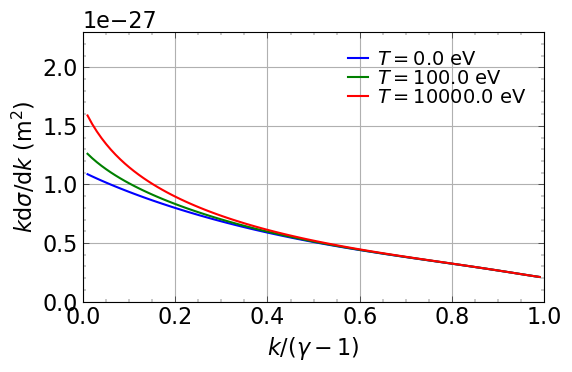

In [12]:
# Reproduce Figure 5

T = [0.0, 100.0, 10.0e3] #eV
colors = ['b','g','r']

kdsdk = np.zeros([nk,len(T)])

for i in range(len(T)):
    
    # For T = 0, set Zstar = 0 instead of getting it from TF model in order to match paper
    if i==0: Zstar = 0
    else:    Zstar = ThomasFermi_Zeff(T[i], rho, Z, A)
    # Zstar = ThomasFermi_Zeff(T[i], rho, Z, A)
    
    dsdk_tfd = np.array([ dif_cs_tfd_mr(k, Z, Zstar, T[i], ni, gamma) for k in ks ])
    kdsdk[:,i] = ks * dsdk_tfd   

fig,ax = plt.subplots(1, 1, figsize=(6,4))
ax.set_xlabel(r'$k/(\gamma-1)$')
ax.set_ylabel(r'$k\mathrm{d}\sigma/\mathrm{d}k$ (m$^2$)')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 2.3e-27])
ax.grid()

for i in range(len(T)):
    ax.plot(ks_over_gm1[1:-1], kdsdk[1:-1,i], '-', c=colors[i], label=r'$T=$'+f'{T[i]} eV')
    
ax.legend()
plt.tight_layout()
# plt.savefig('cs_bremss_tfd_Z29_5MeV.png')
plt.show()

# Calculate cross section for first test problem

In [13]:
# Create table to be used in simulating 40 MeV electrons incident on copper

# first column is electron energy in MeV, 
# columns 1 through nk+1 are kdsdk at photon energy k, 
# and column nk+2 is the total cross section in m^2

T = 0.0
ni = 8.0e28
Zstar = 0.0
Z = 29

m2_to_barn = 1.0e28

energies_MeV = np.array([1.0e-3, 2.0e-3, 5.0e-3, 1.0e-2, 2.0e-2, 5.0e-2, 1.0e-1, 2.0e-1, 5.0e-1,
                         1.0, 2.0, 3.0, 5.0, 6.0, 7.0, 8.0, 9.0,
                         10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0,
                         1.0e2, 2.0e2, 5.0e2, 1.0e3, 2.0e3, 5.0e3, 1.0e4])
n_energies = np.size(energies_MeV)
energy = np.zeros([n_energies,1])
energy[:,0] = energies_MeV

# same values as Geant4 (for now)
k_over_gm1_sb = np.array([1.0e-5, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.97, 0.99, 1.0])

# k_over_gm1 = np.logspace(-7,0,100)
k_over_gm1 = np.linspace(1.0e-7,1.0,100)

nks = np.size(k_over_gm1)

table = np.zeros((n_energies, nks+2))

for i in range(n_energies):
    
    E = energies_MeV[i]    
    EeV = E  * 1.0e6
    gamma = 1.0 + (EeV * constants.e) / me_c2
    gm1 = gamma - 1.0
    ks = k_over_gm1 * gm1
    
    if (gamma <= 2.0):
        dsdk = np.array([ dif_cs_tfd_nr2(k, Z, Zstar, T, ni, gamma) for k in ks ]) * m2_to_barn
        
    else:
        dsdk = np.array([ dif_cs_tfd_mr(k, Z, Zstar, T, ni,gamma) for k in ks ]) * m2_to_barn
        
    kdsdk = dsdk * ks
    
    sigma_ttl = 0.0
    for j in range(nks-1):
        if (j==0):
            sigma_ttl += kdsdk[0]   # * (ks[0] - 0.0) / ks[0]
        elif (j>0):
            dk = ((ks[i+1] - ks[i]) + (ks[i] - ks[i-1])) / 2.0
            sigma_ttl += dsdk[j] * dk
    
    table[i, 0] = E
    table[i, 1:nks+1] = kdsdk
    table[i, -1] = sigma_ttl

    # print total cross section for 40 MeV electrons
    if (i==20):
        print(f'cs={sigma_ttl:.2f} barns')
    
# filename = "brems_cs_tfd_copper.csv"
# np.savetxt(filename, table, delimiter=" ")

cs=59.52 barns


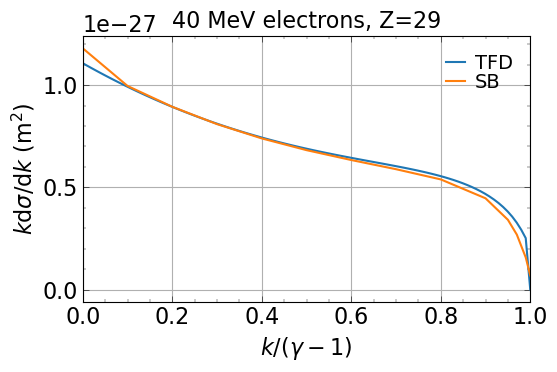

In [17]:
# Compare Seltzer-Berger and TFD differential cross sections

# row from table for 40 MeV
i_40_MeV = 20

# TFD table
kdsdk_tfd = table #np.loadtxt(filename)

# SB table
kdsdk_sb = np.loadtxt('../utils/SB_G4_Z29_kdsdk_MeV_barns.csv')


fig,ax = plt.subplots(1, 1, figsize=(6,4))
ax.set_title('40 MeV electrons, Z=29')
ax.set_xlabel(r'$k/(\gamma-1)$')
ax.set_ylabel(r'$k\mathrm{d}\sigma/\mathrm{d}k$ (m$^2$)')
ax.set_xlim([0.0, 1.0])
# ax.set_ylim([0.0, 2.3e-27])
ax.grid()

ax.plot(k_over_gm1, kdsdk_tfd[i_40_MeV,1:-1] / m2_to_barn, '-', label=r'TFD')
ax.plot(k_over_gm1_sb, kdsdk_sb[i_40_MeV,1:-1] / m2_to_barn, '-', label=r'SB')
    
ax.legend()
plt.tight_layout()
plt.show()

sigma_ttl_tfd = 59.52 barns
sigma_ttl_sb = 66.76 barns


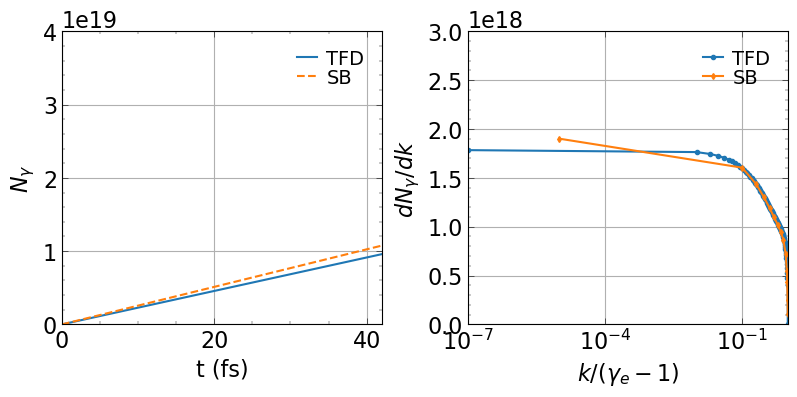

In [15]:
# plot theory curves for figure 9

fig, ax = plt.subplots(1,2,figsize=(8,4))

ax[0].set_xlabel('t (fs)')
ax[0].set_ylabel(r'$N_{\gamma}$')
ax[0].set_xlim([0, 42.0])
ax[0].set_ylim([0.0, 4.0e19])

ax[1].set_xlabel(r'$k/(\gamma_e -1)$')
ax[1].set_ylabel(r'$dN_{\gamma}/dk$')
ax[1].set_xlim([1.0e-7, 1.0])
ax[1].set_ylim([0.0, 3.0e18])
ax[1].set_xscale('log')

for axis in ax: axis.grid()

# theory result for photon count ~~~~~~~~~~~~~~~~

length = 1.6e-6
ne = 1.0e27
ni = 8.0e28
E = 40.0e6 # 40 MeV
ve = calc_beam_velocity_EeV(E, constants.m_e)

sigma_ttl_tfd = kdsdk_tfd[i_40_MeV, -1] # last element of table
print(f'sigma_ttl_tfd = {sigma_ttl_tfd:.2f} barns')
sigma_ttl_tfd /= m2_to_barn

# approximate total cross section for Sb
ks_sb = k_over_gm1_sb * gm1
sigma_ttl_sb = 0.0
for i in range(len(ks_sb)-1):
    if (i == 0):
        dk_sb = ks_sb[1]
        sigma_ttl_sb += kdsdk_sb[i_40_MeV,0]
        
    elif (i > 0):
        dk_sb = ((ks_sb[i+1] - ks_sb[i]) + (ks_sb[i] - ks_sb[i-1])) / 2.0
        sigma_ttl_sb += kdsdk_sb[i_40_MeV,i] * dk_sb / ks_sb[i]
            
print(f'sigma_ttl_sb = {sigma_ttl_sb:.2f} barns')
sigma_ttl_sb /= m2_to_barn

N_theory_pts = 100
time_theory = np.linspace(0, 42.0e-15, N_theory_pts)
Ngamma_theory = ne * ni * ve * length * sigma_ttl_tfd * time_theory
Ngamma_theory_sb = ne * ni * ve * length * sigma_ttl_sb * time_theory

ax[0].plot(time_theory * 1.0e15, Ngamma_theory, '-', label='TFD')
ax[0].plot(time_theory * 1.0e15, Ngamma_theory_sb, '--', label='SB')
ax[0].legend()

# photon energy spectrum ~~~~~~~~~~~~~~~~

# is equation 39 missing a factor of k?

dsdk_tfd = kdsdk_tfd[i_40_MeV,1:-1] / m2_to_barn# / ks 
dndk_tfd = ne * ni * ve * length * time_theory[-1] * dsdk_tfd

dsdk_sb = kdsdk_sb[i_40_MeV,1:-1] / m2_to_barn #/ ks_sb 
dndk_sb = ne * ni * ve * length * time_theory[-1] * dsdk_sb

ax[1].plot(k_over_gm1[:], dndk_tfd[:], '-o', label='TFD')
ax[1].plot(k_over_gm1_sb[:], dndk_sb[:], '-d', label='SB')

ax[1].legend()

fig.tight_layout(pad=0.5, rect=[0,0,1,1])
# plt.savefig('Martinez_2019_fig9.png')
plt.show()

In [16]:
# numerically integrate differential with scipy quadrature
# (according to figure 9a we are expecting sigma_ttl >200 barns)

T = 0.0
ni = 8.0e28
Zstar = 0.0
Z = 29
EeV = 40.0e6

gamma = 1.0 + (EeV * constants.e) / me_c2
gm1 = gamma - 1.0

print(f"{Z} {Zstar} {T} {ni} {gamma}")

from scipy.integrate import quadrature
sigma_ttl = quadrature(dif_cs_tfd_mr, 0.0, gm1, args=(Z, Zstar, T, ni, gamma), vec_func=False)
print(f'sigma_ttl = {sigma_ttl[0] * m2_to_barn} barns')

29 0.0 0.0 8e+28 79.27804734295493
sigma_ttl = 24.465992848952315 barns
